In [1]:
import random as rn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time as ti
import itertools as it
from IPython.display import display, Latex

Disclaimer: I will ommit comments from code where I feel the context or variable names etc clearly illustrate things.

# Creating a simulation of blackjack

Firstly I initialise the deck which contains 52 cards. I include the suit but that is not essential as blackjack outcomes are invaraint of suit:

In [2]:
full_deck = ["2","3","4","5","6","7","8","9","10","J","Q","K","A"]*4

We now have to calculate the score associated with a given hand. We must assign a dynamic rule to the ace which sets all aces equal to eleven initially. I the hand is bust, the first ace is set to 1. If still bust the first two aces are set to 1 and so on:

In [3]:
def score(current_hand):
    score = 0
    high_aces = 0
    low_aces = 0
    for i in current_hand:
        if i[0] != "A":
            if i.isdigit() and int(i) > 1:
                 score += int(i)
            else:
                 score += 10
        if i[0] == "A": 
            high_aces += 1
        
    while high_aces > 0:
        if score + 11*high_aces + low_aces < 22:
            score += 11*high_aces 
            high_aces = 0
        if score + 11*high_aces + low_aces > 21:
            high_aces -= 1
            low_aces += 1

    return score + low_aces

## Object Oriented Programming
For the model I will employ 3 objects. These are classes which have class specific methods. The objects are the deck, the player and the game and they all are required so apply several actions via their methods:

### The Deck
The deck must:
- Show deck in its current state
- Draw from the deck in its current state
- Remove specified cards from the deck

In [4]:
class deck:
    def __init__(self, num_decks = 1):
        self.deck = list(np.random.permutation(full_deck*num_decks))
    def show_deck(self):
        return(self.deck)
        
    def draw(self):
        if len(self.deck) > 0:
            x = self.show_deck().pop()
            return(x)
            self.deck.remove(x)   

        else:
            return(None)
        
    def remove(self,to_be_removed):
        for i in to_be_removed:
            if i in self.show_deck():# To avoid errors
                self.deck.remove(i)


### The Player
The player must:
- Show hand
- Draw new card given a deck
- Insert a specified card to their hand (Essential for the dealer's hidden card and for simulating specific hands)

In [5]:
class player:
    def __init__(self):
        self.current_hand = []
        
    def show_hand(self):
        return(self.current_hand)
    
    def draw(self,current_deck):
        self.current_hand = list(self.current_hand) + [current_deck.draw()]#needs work
            
    def take_card(self,hidden_card):
        self.current_hand = np.append(self.current_hand,hidden_card)
        
    def score(self):
        return score(self.current_hand)

### The Game
The game must:
- Initialize dealer, player, game, deck given a number of decks
- Perform the initial deal giving the player two visible cards and giving the dealer one visible card and one hidden card
- Be capable of fixing the hands of both dealer and player for my analysis
- At any point show the hands of both parties, the hidden card or the deck

In [6]:
class game:
    def __init__(self,num_decks = 1, player_initial_hand = [], dealer_initial_hand = []):

        #Add initial hand method that draws etc

        self.player = player()
        self.dealer = player()
        self.deck = deck(num_decks)
        self.hidden_card = player()
        
        for i in list(player_initial_hand) + list(dealer_initial_hand):
            self.deck.remove(i)
            
        for j in player_initial_hand:
            self.player.take_card(j)
            
        while len(self.player.show_hand()) < 2:
            self.player.draw(self.deck)
        
            
        for j in dealer_initial_hand:
            self.dealer.take_card(j)
            
        if len(self.dealer.show_hand()) < 1:
            self.dealer.draw(self.deck)

        
        self.hidden_card.draw(self.deck)
        self.dealer.take_card(self.hidden_card.show_hand())#We just add it now but later I will account for the fact that this information is not visible
        
# Define functions to show the hands, hidden card and current deck
    def show_player(self):
        return(self.player.show_hand())

    def show_dealer(self):
        return(self.dealer.show_hand())
    
    def show_hidden(self):
        return(self.hidden_card)
    
    def show_deck(self):
        return(self.deck.show_deck())

## Startegy
I will employ several strategies for playing the games, each one using different levels of complexity and thereofre implied player skill. The first strategy will be for a layman with no knowledge or interest in the game. For this person, I will determine the best value for them to stick at to maximize their win rate. 
### Layman Startegy

I run the game drawing two cards for the player and dealer. For each possible stick value $i \in [10,21]$ I will simulate $10^6$ games and where the player sticks if their hand has a score $\geq i$. I will then present the win, loss, tie proportions for each stick threshold. Firstly I define a function which determines the winner or if a tie has taken place:

In [7]:
def decision(player,dealer):
    if player.score() < 22:#Not bust
        if player.score() > dealer.score():#Player Wins
            return([1,0,0], player.show_hand())

        if player.score() < dealer.score() and dealer.score() < 22:#Dealer Wins
            return([0,1,0], dealer.show_hand())

        if dealer.score() > 21:#Dealer bust
            return([1,0,0], [])

        if player.score() == dealer.score():#Tie
            return([0,0,1], [])
    if player.score() > 21: #Player bust
        return(np.array([0,1,0]), dealer.show_hand())

I now run the simulations with the player sticking if they score on or above $i$:

In [8]:
totals = {}
    
total_iterations = 10**6

start = ti.time()
for i in range(10,22):
    iterations = total_iterations
    current_score = np.array([0,0,0])
    while iterations > 0:
        test = game()
 
        while test.player.score() < i:
            test.player.draw(test.deck)

        while test.dealer.score() < 17:
            test.dealer.draw(test.deck)
#--------------------------------------------------------------------------------
        temp, hand = decision(test.player, test.dealer)#[1,0,0] for player win, [0,1,0] for dealer win, [0,0,1] for tie
        current_score += temp
#------------------------------------------------------------------------------------
        iterations -= 1
    totals[str(i)] = current_score
ti.time() - start

1144.6312663555145

In [10]:
totals#110

,Player Wins,Dealer Wins,Ties
10,391669,551795,56536
11,401159,537882,60959
12,415467,518675,65858
13,418972,508480,72548
14,421468,499074,79458
15,419585,493822,86593
16,415112,490878,94010
17,408550,489296,102154
18,398456,513282,88262
19,361546,564782,73672


In [11]:
[i[0]/10**6 for i in totals.values()]

TypeError: 'numpy.ndarray' object is not callable

In [9]:
totals = pd.read_csv("Integer_Stick_Data.csv",index_col = 0) #No need to rerun

In [12]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], round(y[i],4), round(y[i],4), ha = 'center',
                 bbox = dict(facecolor = 'red', alpha =.8))

In [83]:
def custom_hist(labels, data, xlabel = None, ylabel = None, title = None, boxes = False, proportions = (12,5)):
    if proportions != []:
        fig = plt.figure(figsize=proportions)
    plt.bar(labels, data, color = "red")
    plt.grid()
    if boxes == True:
        for i in range(len(labels)):
            plt.text(labels[i], round(data[i],4), round(data[i],4), ha = 'center', va = "bottom",bbox = dict(facecolor = 'red', alpha =.8))

The below histogram shows how often the player wins with a given startegy and the black line shows the dealer bust rate which is the baseline for any strategy as this level can be exceeded by simply sticking on the draw:

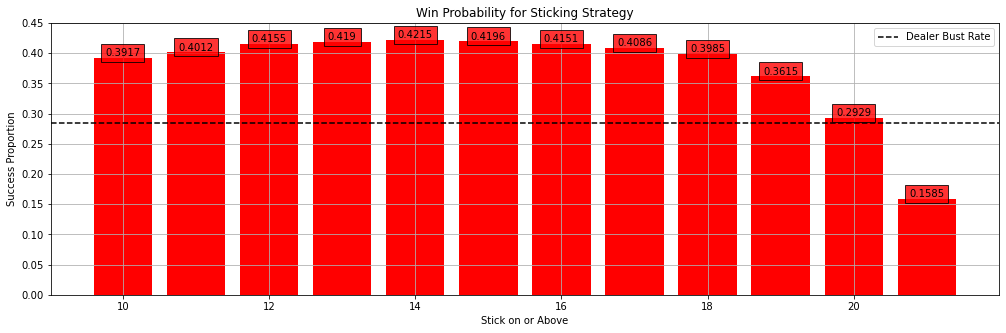

In [86]:
custom_hist(totals.index, list(totals["Player Wins"]/10**6), boxes = True, proportions = (17,5))
plt.axhline(y=.285, color='black', linestyle='--', label = "Dealer Bust Rate")
plt.title("Win Probability for Sticking Strategy")
plt.xlabel("Stick on or Above")
plt.ylabel("Success Proportion")
plt.ylim(0,0.45)
plt.legend()
plt.savefig("Simple_Strategy.png", dpi = 300, bbox_inches='tight')

We identify holding at 14 or above as the optimal holding value. I will simulate $10^7$ games with this stategy to determine some properties of the game. These will include:
- Number of cards in winners hand
- Types of cards in winners hand
- Win, draw, tie rate
This will illustrate how different cards are more likely to result ina  win if present in a hand.

In [104]:
#------------------------------------------------------------------------------------
cards_in_hand = dict([(key, 0) for key in full_deck[0:13] + ["non_bust_wins"]])

num_cards = dict([key,0] for key in range(2,20))
#------------------------------------------------------------------------------------
    
iterations, current_score = 10**7, np.array([0,0,0])

start = ti.time()

while iterations > 0:
    test = game()

    while test.player.score() < 14:
        test.player.draw(test.deck)

    while test.dealer.score() < 17:
        test.dealer.draw(test.deck)

    temp, hand = decision(test.player, test.dealer)#[1,0,0] for player win, [0,1,0] for dealer win, [0,0,1] for tie
    
    current_score += temp
    for card in hand:
        cards_in_hand[card] += 1
        num_cards[len(hand)] += 1        
    if len(hand) != 0:
        cards_in_hand["non_bust_wins"] += 1

#------------------------------------------------------------------------------------ 
    iterations -= 1
print(list(current_score))
ti.time() - start

[4207856, 4998464, 793680]


938.4305768013

In [16]:
current_score = [4207856, 4998464, 793680]#Save us calcualating again

In [17]:
#pd.DataFrame({ "Num Cards in Winning Hand":[i for i in num_cards.values() if i != 0]}, index = range(2,len([i for i in num_cards.values() if i != 0])+2)).to_csv("Num_Cards_Winning_Hand.csv") 
#pd.DataFrame({"Cards In Winning Hand":cards_in_hand.values()}, index = cards_in_hand.keys()).to_csv("Cards_Winning_Hand.csv")
wins = sum(current_score[0:2])

In [18]:
temp = pd.read_csv("Num_Cards_Winning_Hand.csv",index_col = 0)["Num Cards in Winning Hand"]
print("Looking up to three draws gets:", str(round(sum(temp[:4]/sum(temp)),6)), "of all winning hands")#Crucially not all hands but effectivley the same I think....
print("Looking up to five draws gets:", str(round(sum(temp[:6]/sum(temp)),6)), "of all winning hands")#Crucially not all hands but effectivley the same I think....
sum(temp[:6]/sum(temp))#Five draws gets 99998 per 100000
temp = pd.read_csv("Cards_Winning_Hand.csv", index_col = 0)
print("Average cards per winning hand:",str(round(float(sum(list(temp["Cards In Winning Hand"][:-1]))/temp.iloc[[13]]["Cards In Winning Hand"]),4)))         

Looking up to three draws gets: 0.996626 of all winning hands
Looking up to five draws gets: 0.999993 of all winning hands
Average cards per winning hand: 2.639


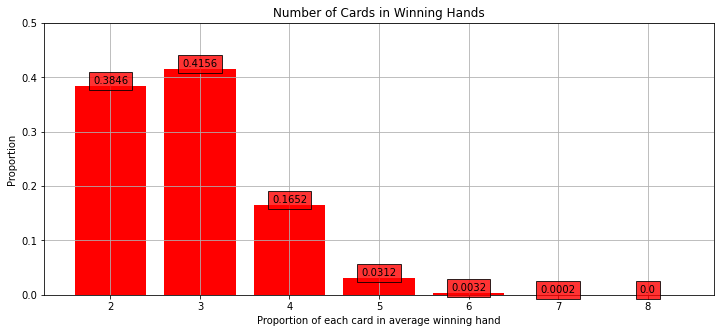

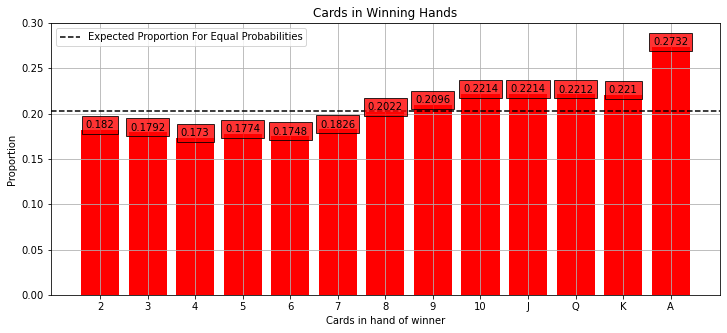

In [19]:
temp = pd.read_csv("Num_Cards_Winning_Hand.csv", index_col = 0)
custom_hist(temp.index, list(temp["Num Cards in Winning Hand"]/sum(temp["Num Cards in Winning Hand"])), boxes = True)
plt.ylim(0,.5)
plt.title("Number of Cards in Winning Hands")
plt.xlabel("Proportion of each card in average winning hand")
plt.ylabel("Proportion")
plt.show()

temp = pd.read_csv("Cards_Winning_Hand.csv", index_col = 0)
custom_hist(temp.index[:-1],temp["Cards In Winning Hand"][:-1]/float(temp.iloc[[13]]["Cards In Winning Hand"]), boxes = True)
plt.axhline(y=1/13*2.639, color='black', linestyle='--',  label = "Expected Proportion For Equal Probabilities")
plt.title("Cards in Winning Hands")
plt.xlabel("Cards in hand of winner")
plt.ylabel("Proportion")
plt.ylim(0,.3)
plt.legend(loc='upper left')

### I will now answer the question "How often does the dealer go bust?":

In [20]:
total_iterations = 10**6
scores = dict([str(key),0] for key in range(2,30))
iterations = total_iterations
bust = 0
start = ti.time()
for i in range(10,22):
    while iterations > 0:
        test = game()

        while test.dealer.score() < 17:
            test.dealer.draw(test.deck)
            
        if  test.dealer.score() > 21:
            bust += 1
        scores[str(test.dealer.score())] += 1

        iterations -= 1
ti.time() - start

83.23600101470947

In [80]:
custom_hist(range(17,27),[i/sum([i for i in scores.values() if i != 0]) for i in scores.values() if i != 0], boxes = True, proportions = (17,5))
plt.axvline(x=21.5, color='black', linestyle='--',  label = "Expected Proportion For Equal Probabilities")
plt.legend(["Proportion Bust: " + str(round(bust/total_iterations,4))], loc='upper right',prop={'size': 20})
plt.ylim(0,0.19)
plt.title("Dealer Score Distribution When Sticking on 17 +")
plt.xlabel("Dealer Score")
plt.ylabel("Proportion")
plt.savefig("Dealer_Score_Dist.png", dpi = 700, bbox_inches='tight')

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

### For the dealers first card, what is his final score distribution since we dont know the hidden card?

In [34]:
total_iterations = 10**5
percard = dict([str(key),0] for key in range(17,27))
scores = {}

start = ti.time()
for card in np.unique(full_deck):
    iterations = total_iterations
    percard = dict([str(key),0] for key in range(17,27))
    while iterations > 0:
        test = game(dealer_initial_hand = [card])
        while test.dealer.score() < 17:
            test.dealer.draw(test.deck)


        percard[str(test.dealer.score())] += 1
        iterations -= 1
    scores[str(card)] = percard 
ti.time() - start

111.63971900939941

I now make histograms corresponding to the final dealer score distributon if the dealer's visible card is that shown in the title:

In [52]:
np.unique(full_deck)

array(['10', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'J', 'K', 'Q'],
      dtype='<U2')

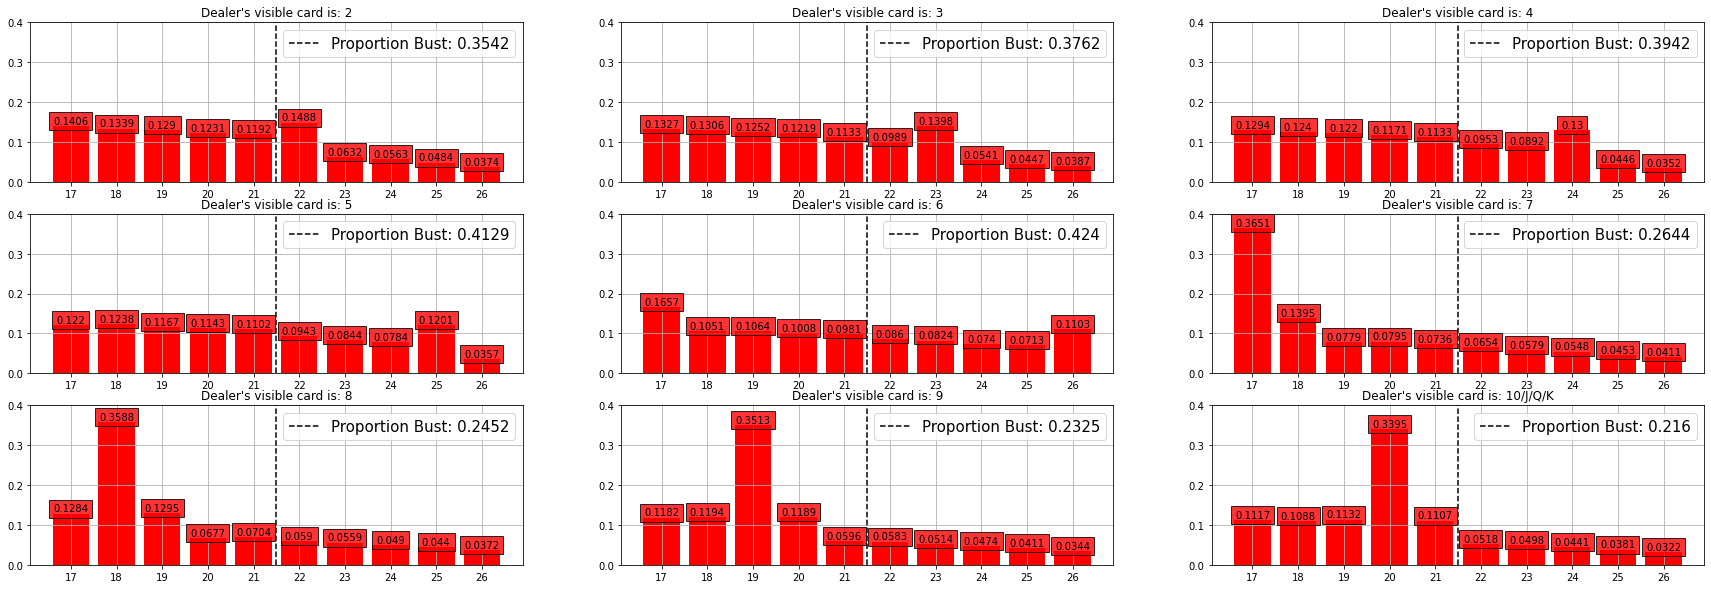

In [60]:
fig = plt.figure(figsize=(30,13.5))
for i in range(0,9):
    ax = fig.add_subplot(4,3,i+1)
    #Fix then blow into proportions
    current_card = ['2', '3', '4', '5', '6', '7', '8', '9','10'][i]
    plt.axvline(x=4.5, color='black', linestyle='--',  label = "Expected Proportion For Equal Probabilities")
    custom_hist(list(scores[current_card].keys()),np.array(list(scores[current_card].values()))/sum(list(scores[current_card].values())), boxes = True, proportions = [])
    bust = sum(list(scores[current_card].values())[5:])
    plt.legend(["Proportion Bust: " + str(round(bust/100000,4))], loc='upper right',prop={'size': 15})
    if current_card == "10":
        current_card = "10/J/Q/K"
    ax.title.set_text("Dealer's visible card is: " + str(current_card))
    #ax.legend(loc='upper right')
    ax.set_ylim([0,.4])
#plt.show()
plt.savefig("Dealer_Complete_score.png", dpi = 300, bbox_inches='tight')

In [68]:
def custom_hist(labels, data, xlabel = None, ylabel = None, title = None, boxes = False, proportions = (12,5)):
    if proportions != []:
        fig = plt.figure(figsize=proportions)
    plt.bar(labels, data, color = "red")
    plt.grid()
    if boxes == True:
        for i in range(len(labels)):
            plt.text(labels[i], round(data[i],4), round(data[i],2), ha = 'center', va = "bottom",bbox = dict(facecolor = 'red', alpha =.8))

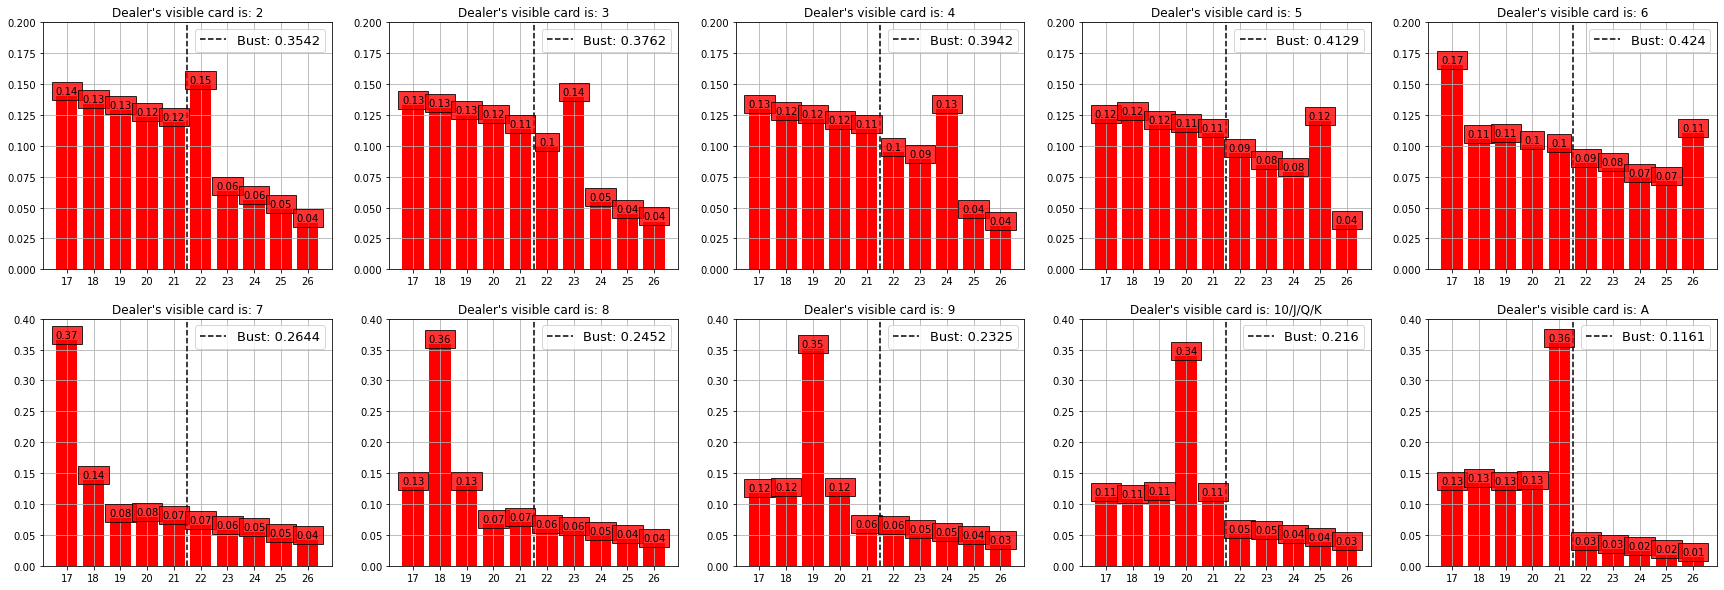

In [77]:
fig = plt.figure(figsize=(30,10))
for i in range(0,10):
    ax = fig.add_subplot(2,5,i+1)
    #Fix then blow into proportions
    current_card = ['2', '3', '4', '5', '6', '7', '8', '9','10', 'A'][i]
    plt.axvline(x=4.5, color='black', linestyle='--',  label = "Expected Proportion For Equal Probabilities")
    custom_hist(list(scores[current_card].keys()),np.array(list(scores[current_card].values()))/sum(list(scores[current_card].values())), boxes = True, proportions = [])
    bust = sum(list(scores[current_card].values())[5:])
    plt.legend(["Bust: " + str(round(bust/100000,4))], loc='upper right',prop={'size': 13})
    if current_card == "10":
        current_card = "10/J/Q/K"
    ax.title.set_text("Dealer's visible card is: " + str(current_card))
    #ax.legend(loc='upper right')
    if i < 5:
        ax.set_ylim([0,.2])
    if i >= 5:
        ax.set_ylim([0,.4])
#plt.show()
plt.savefig("Dealer_Complete_score.png", dpi = 300, bbox_inches='tight')

# Optimal Stategy

We now move onto the next stage of the project which is calculation of the optimal blackjack startegy for single deck blackjack. This will be done by simulating every possible hand and by properly weighting all possible future hands and their win probabilities I will calculate the optimal move at any hand. The first thing to do is to remove all "face" cards. They are equivalent to "10" and so only act to complicate things:

In [141]:
full_deck = ["2","3","4","5","6","7","8","9","1","1","1","1","0"]*4 #1 == 10, 0 == A
options = ["2","3","4","5","6","7","8","9","1","0"]

Now I need to calculate every possible hand in single hand blackjack:#Needs to be edited to function with more than 2 tens

In [386]:
def score(current_hand):
    score = 0
    high_aces = 0
    low_aces = 0
    for i in current_hand:
        if i[0] != "0":
            if i.isdigit() and int(i) > 1:
                 score += int(i)
            else:
                 score += 10
        if i[0] == "0": 
            high_aces += 1
        
    while high_aces > 0:
        if score + 11*high_aces + low_aces < 22:
            score += 11*high_aces 
            high_aces = 0
        if score + 11*high_aces + low_aces > 21:
            high_aces -= 1
            low_aces += 1

    return score + low_aces

In [380]:
table = {}
start = ti.time()

current = []
       
for i in (full_deck[0:13]):
    for j in (full_deck[0:13]):
        temp = [i,j]
        temp.sort()
        if "".join(temp)+"s"+"0" not in list(table.keys()):
            for dealer_card in (full_deck[0:13]):    
                table["".join(temp)+"s"+dealer_card] = np.array([0,0,0])
                table["".join(temp)+"h"+dealer_card] = np.array([0,0,0])
            if score(temp) < 22: #It makes sense to do all because 21 is guarenteed stick but crucially I will be weighting success and different positions will have more ties depsite having blackjack
                current.append(list(temp))

for num_starting_cards in range(0,21):
    new = []
    for i in current:
        for j in (full_deck[0:13]):
            if score(list(i) + [j]) < 22:
                max_num_cards = 0
                for cycle in (full_deck[0:13]):
                    if (list(i) + [j]).count(cycle) > max_num_cards:
                        max_num_cards = (list(i) + [j]).count(cycle)
                if max_num_cards < 5 and (list(i) + [j]).count("1") < 16:#Single deck. Only maintain hands with four of the same card and 16 for 10 as the 10 cardappears 16 times
                    temp = i + [j]
                    temp.sort()
                    for dealer_card in [card for card in full_deck[0:13] if (i + [j]).count(card) < 4]:#Tens arent a problem as more than 2 is bust anyway
                        table["".join(temp)+"s"+dealer_card] = np.array([0,0,0])
                        table["".join(temp)+"h"+dealer_card] = np.array([0,0,0])
                    if temp not in new:
                        new.append(list(temp))
 
        current = new
        
print(ti.time()-start)
pd.DataFrame(pd.Series(table,index=table.keys())).to_csv("data.csv")

0.4929542541503906


In [381]:
print(str(int(len(table)/2))+" Possibe Hands in Single Deck Blackjack")#1200

19620 Possibe Hands in Single Deck Blackjack


Now we make some alterations to the dataframe:

In [382]:
test = pd.DataFrame(pd.Series(table,index=table.keys()))

dealer_cards = []
hand_sizes = []
player_score = []
decisions = []
hands = []
for i in test.index:
    hand, decision,dealer = convert(i)
    player_score.append(score(hand))
    hand = [int(i) for i in hand]
    hands.append(hand)
    hand_sizes.append(len(hand))
    dealer_cards.append([int(i) for i in dealer])
    decisions.append(decision)

test["Player Wins"] = 0
test["Dealer Wins"] = 0
test["Ties"] = 0
test["Hands"] = hands
test["Dealer Card"] = dealer_cards
test["Hand Size"] = hand_sizes
test["Player Score"] = player_score
test["Decision"] = decisions
test["Optimal"] = 0
test["Expected Return"] = 0
del test[0]
test.to_csv("data.csv")

Above I have adopted a consistent key structure in the dictionary. A particular hand has the form PlayerHand/Stick or Hit/DealerVisibleCard. For example, a player with the hand 2,2 that is hitting with the dealer holding 7 is "22h7" where the player hand is always sorted. I now make a function to convert dictionary keys back to hands:

In [387]:
def convert(hand):
    new_hand = []
    hand = list(hand)
    for i in hand:
        if i == "s" or i == "h":
            break
        else:
            new_hand.append(i)
    
    dealer = hand[-1]
        
    if "h" in hand:
        stick = 1
    else:
        stick = 0
    
    return(new_hand,stick,[dealer])

In [388]:
def runner(hand,iterations):
    current_score = np.array([0,0,0])
    hand, total_draws, dealer_first_card = convert(hand)
    while iterations > 0:
        test = game(player_initial_hand = hand, dealer_initial_hand = dealer_first_card)
        allowed_draws =  total_draws
        while allowed_draws > 0:
            test.player.draw(test.deck)
            allowed_draws -= 1

#------------------------------------------------------------------------------------

            while allowed_draws > 0:
                test.player.draw(test.deck)
                allowed_draws -= 1


        while score(test.dealer.show_hand()) < 17:
            test.dealer.draw(test.deck)
        
        
        winner, hand = decision(test.player, test.dealer)
        
        iterations -= 1
        current_score += winner
            
#------------------------------------------------------------------------------------
    return(current_score)

In [397]:
num_new_simulations = 100
#------------------------------------------------------------------------------------
#Import current simulation data
#------------------------------------------------------------------------------------
data = pd.read_csv("data.csv",index_col = 0)
table = {}
for i,j,k,l in zip(data.index, data["Player Wins"], data["Dealer Wins"], data["Ties"]):
    table[i] = np.array([j,k,l])
#------------------------------------------------------------------------------------  
#Run new simulations and add to cumulative data
#------------------------------------------------------------------------------------
start = ti.time()
for i in list(table.keys()):
    if "s" in list(i):
        table[i] = list(table[i] +  runner(i,num_new_simulations))
print(ti.time()-start)
#------------------------------------------------------------------------------------
#Create dataframe to be created and save
#------------------------------------------------------------------------------------
player_wins = []
dealer_wins = []
ties = []
for i in table.values():
    player_wins.append(i[0])
    dealer_wins.append(i[1])
    ties.append(i[2])
data["Player Wins"] = np.array(player_wins)
data["Dealer Wins"] = np.array(dealer_wins)
data["Ties"] = np.array(ties)
data.to_csv("data.csv")

219.93650317192078


### Use above data to calculate optimal strategy:

In [398]:
data = pd.read_csv("data.csv",index_col = 0)
data

,Player Wins,Dealer Wins,Ties,Hands,Dealer Card,Hand Size,Player Score,Decision,Optimal,Expected Return
22s2,63,35,13,"[2, 2]",[2],2,4,0,0,0
22h2,0,0,0,"[2, 2]",[2],2,4,1,0,0
22s3,70,33,8,"[2, 2]",[3],2,4,0,0,0
22h3,0,0,0,"[2, 2]",[3],2,4,1,0,0
22s4,63,38,10,"[2, 2]",[4],2,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...
00002222333h8,0,0,0,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[8],11,21,1,0,0
00002222333s9,69,30,12,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[9],11,21,0,0,0
00002222333h9,0,0,0,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[9],11,21,1,0,0
00002222333s1,64,29,18,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[1],11,21,0,0,0


In [216]:
#Says if hand b is a parent of hand a
def bigger(hand,compare_hand):
    missing_cards = 0
    for i in hand:
        if i not in compare_hand:
            missing_cards += 1
        if i in compare_hand:
            compare_hand.remove(i)
    if missing_cards < 1:
        return(True)
    if missing_cards >= 1:
        return(False)

# Data Analysis

- Go through hands of length 10. They must be terminal hands requiring a stick as therea re no valid length 11 hands.
- Calculate the associated expected return of these hands and save them to the data frame.
- Move to length 9 hands. Expected return is weighted expected returns of length 10 hands that can be obtained from that length 9 hand. Repeat. 


First We need a function to calculate the probability that a hand will be drawn form another hand eg Pr([2,2] -> [2,2,3])def likelihood(current,dealer,target):
    for i in current:
        target.remove(i)
    to_draw = target[0]
    if to_draw == "10":
        count = 16
    else:
        count = 4
    for i in current + dealer:
        if i == to_draw:
            count -= 1
    print(count)
    proability = count/(52 - 1 - len(current))
    return(proability)
    

In [255]:
def likelihood(current,dealer,target):
    for i in current:
        target.remove(i)
    to_draw = target[0]
    if to_draw == "10":
        count = 16
    else:
        count = 4
    for i in current + dealer:
        if i == to_draw:
            count -= 1
    proability = count/(52 - 1 - len(current))
    return(proability)

In [374]:
data = pd.read_csv("data.csv",index_col = 0)

In [375]:
#for i in data[data["Hand Size"] == 11].index:
data["Expected Return"] = (data["Player Wins"] - data["Dealer Wins"])/(data["Player Wins"] + data["Dealer Wins"])

In [376]:
for i in data[data["Hand Size"] == 11].index:
    if "h" in list(i):
        data.at[i,"Optimal"] = 0
    else:
        data.at[i,"Optimal"] = 1

In [378]:
data[data["Hand Size"] == 11]

,Player Wins,Dealer Wins,Ties,Hands,Dealer Card,Hand Size,Player Score,Decision,Optimal,Expected Return
00002222333s3,311,155,46,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[3],11,21,0,1,0.334764
00002222333h3,0,1,0,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[3],11,21,1,0,-1.000000
00002222333s4,327,153,32,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[4],11,21,0,1,0.362500
00002222333h4,0,1,0,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[4],11,21,1,0,-1.000000
00002222333s5,327,155,30,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[5],11,21,0,1,0.356846
00002222333h5,0,1,0,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[5],11,21,1,0,-1.000000
00002222333s6,340,132,40,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[6],11,21,0,1,0.440678
00002222333h6,0,1,0,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[6],11,21,1,0,-1.000000
00002222333s7,324,142,46,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[7],11,21,0,1,0.390558
00002222333h7,0,1,0,"[0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[7],11,21,1,0,-1.000000


In [371]:
current_num = 10
for i in data[data["Hand Size"] == current_num].index:
    ror = []
    if "h" in list(i):
        for j in options:
            temp = list(i)[0:-2]
            temp.insert(-1,j)
            temp.sort()
            temp = temp + list(i)[-2:]
            temp = "".join(temp)
            #Something wrong here
            if temp in data[data["Hand Size"] == current_num + 1].index:
                if data["Optimal"][temp] == 0:
                    temp.replace("h","s")
                daughter_hand, daughter_choice, daughter_dealer = convert(i)
                parent_hand, parent_choice, parent_dealer = convert(temp)  
                p = likelihood(daughter_hand, daughter_dealer, parent_hand)
                ror.append(p * data["Expected Return"][temp])
            if temp not in data[data["Hand Size"] == current_num + 1].index:
                daughter_hand, daughter_choice, daughter_dealer = convert(i)
                parent_hand, parent_choice, parent_dealer = convert(temp)  
                p = likelihood(daughter_hand, daughter_dealer, parent_hand)
                ror.append(-p)
        ror = sum(ror)
        data.at[i,"Expected Return"] = ror
        alternative = i
        alternative.replace("h","s")
        if data["Expected Return"][alternative] < data["Expected Return"][i]:
            data.at[i,"Optimal"] = 1
        if data["Expected Return"][alternative] >= data["Expected Return"][i]:
            data.at[alternative,"Optimal"] = 1

In [372]:
current = 2
sum(data[data["Hand Size"] == current]["Expected Return"][1::2])/len(data[data["Hand Size"] == current]["Expected Return"][1::2])

nan

In [373]:
list(data[data["Hand Size"] == 10]

,Player Wins,Dealer Wins,Ties,Hands,Dealer Card,Hand Size,Player Score,Decision,Optimal,Expected Return
0002222333s3,313,165,34,"[0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[3],10,20,0,0,0.309623
0002222333h3,0,1,0,"[0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[3],10,20,1,1,-0.707317
0002222333s4,315,163,34,"[0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[4],10,20,0,0,0.317992
0002222333h4,0,1,0,"[0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[4],10,20,1,1,-0.707317
0002222333s5,326,147,39,"[0, 0, 0, 2, 2, 2, 2, 3, 3, 3]",[5],10,20,0,0,0.378436
...,...,...,...,...,...,...,...,...,...,...
0000223334h8,0,1,0,"[0, 0, 0, 0, 2, 2, 3, 3, 3, 4]",[8],10,21,1,1,-0.707317
0000223334s9,287,160,65,"[0, 0, 0, 0, 2, 2, 3, 3, 3, 4]",[9],10,21,0,0,0.284116
0000223334h9,0,1,0,"[0, 0, 0, 0, 2, 2, 3, 3, 3, 4]",[9],10,21,1,1,-0.707317
0000223334s1,239,183,90,"[0, 0, 0, 0, 2, 2, 3, 3, 3, 4]",[1],10,21,0,0,0.132701


In [331]:
print(list(data[data["Hand Size"] == 10]["Expected Return"][1::2]))

[-0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707318, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707318, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707316, -0.7073170731707317, -0.7073170731707317, -0.7073170731707316, -0.7073170731707316, -0.7073170731707316, -0.7073170731707317, -0.7073170731707316, -0.7073170731707316, -0.7073170731707317, -0.7073170731707317, -0.7073170731707316, -0.7073170731707316, -0.7073170731707316, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.7073170731707317, -0.707317073